# Предсказание моих шахматных результатов. Ход конём

Приветствую всех! Что собственно говоря, происходит?

Меня зовут Максим, и я шахматист. Я играю в шахматы с 3 лет, и это был мой осознанный выбор (конечно же нет). Я имею звание КМС и очень люблю играть в шахматы онлайн. Я сейчас играю на одном из лучших сайтов для игры в шахматы онлайн - lichess.org. На апрель 2021 года у меня было сыграно около 2000 партий, в основном это блиц (blitz, контроль времени 3-5 минут на партию) или пуля (bullet, контроль времени 1-2 минуты на партию). Мне стало интересно, возможно ли предсказать с достаточной точностью, выиграю ли я определенную партию или нет, исходя из данных, которые можно собрать с сайта lichess? Я скачал базу моих партий с этого сайта и начал разбираться...

## 1. Постановка задачи. Обзор имеющихся данных

Загружаем нужные библиотеки для начала

In [114]:
%matplotlib inline
import re
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, roc_curve, auc
from chess_lib import create_df_from_pgn, create_my_result, plot_auc_roc, count_rate, fit_model
import pickle
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 12

Здесь библиотека chess_lib - это файл, который я создал сам. В нём содержатся функции для парсинга pgn файла и создания из его содержимого Dataframe, создания целевой переменной и прочие вспомогательные функции. Когда я буду пользоваться функцией из этой библиотечки, я укажу это в тексте

База данных партий хранится в файле формата .pgn (это такой стандарт для шахматных баз данных). Это по сути, текстовый файл, отформатированный определенным образом. Давайте взглянем на его кусочек.

In [2]:
with open('C:\python\ML_coursera\Data Science\lichess_base\lichess_shahmatpatblog_2021-12-17.pgn', 'r', encoding='utf-8') as f:
    text_file = f.read()
print(text_file[:1000])

[Event "Rated Blitz game"]
[Site "https://lichess.org/QKbPbAnL"]
[Date "2021.12.15"]
[White "MichalPawlak"]
[Black "shahmatpatblog"]
[Result "1-0"]
[UTCDate "2021.12.15"]
[UTCTime "08:15:19"]
[WhiteElo "2281"]
[BlackElo "2298"]
[WhiteRatingDiff "+6"]
[BlackRatingDiff "-6"]
[Variant "Standard"]
[TimeControl "180+2"]
[ECO "E10"]
[Opening "Blumenfeld Countergambit"]
[Termination "Time forfeit"]

1. d4 { [%clk 0:03:00] } 1... Nf6 { [%clk 0:03:00] } 2. c4 { [%clk 0:03:00] } 2... c5 { [%clk 0:03:01] } 3. d5 { [%clk 0:03:01] } 3... b5 { [%clk 0:03:01] } 4. Nf3 { [%clk 0:03:01] } 4... e6 { [%clk 0:02:52] } 5. Bf4 { [%clk 0:02:24] } 5... bxc4 { [%clk 0:02:37] } 6. Nc3 { [%clk 0:02:00] } 6... Bb7 { [%clk 0:02:33] } 7. e4 { [%clk 0:02:00] } 7... Qa5 { [%clk 0:02:23] } 8. Bd2 { [%clk 0:01:55] } 8... Qb6 { [%clk 0:01:44] } 9. Qc2 { [%clk 0:01:51] } 9... d6 { [%clk 0:01:36] } 10. Bxc4 { [%clk 0:01:50] } 10... e5 { [%clk 0:01:33] } 11. O-O { [%clk 0:01:49] } 11... Be7 { [%clk 0:01:33] } 12. Rfb1 { [%

Здесь, для примера, отображена информация о последней (по хронометражу) игре. Данным образом форматируется каждая партия в базе. Структура следующая: вначале идёт заголовок партии, затем ходы партии, затем предыдущая партия и т.д. Мы можем воспользоваться следующей информацией:

Event - тип события. Может быть обычная блиц партия, обычная пуля-партия, какой-нибудь турнир (если сыграна в турнире)

Site - ссылка на страничку партии

Date - дата партии

White - никнейм игрока, играющего белыми

Black - никнейм игрока, играющего черными

Result - результат партии (1-0, 0-1, 1/2-1/2)

UTCDate - дата UTC

UTCTime - время UTC (-4 часа от моего часового пояса)

WhiteElo - рейтинг (Elo) белых

BlackElo - рейтинг (Elo) черных

WhiteRatingDiff - изменение рейтинга белых по результату данной партии

BlackRatingDiff - изменение рейтинга черных по результату данной партии

Variant - тип выбранного режима игры (обычные, шахматы Фишера, поддавки и т.п.). Я играю только обычные (Standard)

TimeControl - контроль времени. "180+2" например, значит, что контроль времени 3 минуты (180 с) с добавлением 2 с на ход.

ECO - дебютный индекс партии. Определяет, какой дебют был разыгран в партии

Termination - тип окончания партии. Нормальное значит кто-то сдался, или мат, или согласились на ничью. Может быть еще просрочка времени

Набор ходов партии в виде стандартной шахматной нотации

In [3]:
path_to_file = 'C:\python\ML_coursera\Data Science\lichess_base\lichess_shahmatpatblog_2021-12-17.pgn'
feature_names = ['Event', 'White', 'Black', 'Result', 'UTCDate', 'UTCTime', 'WhiteElo', 'BlackElo',\
                 'Variant', 'TimeControl', 'ECO']

Я скачал базу данных своих партий на 20.04.2021 в формате .pgn, которая содержит в текстовом виде информацию о сыгранных мной партиях на сайте lichess.org. Она содержит 1952 партий за период 05.2020 - 04.2021. Часть этих партий будет использоваться для обучения, другая часть - для проверки модели. Выше я прописал путь к файлу и задал список параметров, которые я хочу выдернуть из базы данных. Мне нужны далеко не все из имеющихся данных.

Моя задача - предсказать результат партий из тестового набора игр (разобью базу данных при помощи train_test_split позже). Предсказание заключается в определении, выиграю ли я эту партию или нет. Это задача бинарной классификации. Для упрощения задачи, ничейные результаты принимаются за поражения (ничьи в блиц бывают редко и их очень трудно предсказать).

## 2. Предобработка данных

Для просмотра кода моих функций см. файл chess_lib.py. Функция create_df_from_pgn() преобразует файл .pgn в датафрейм с указанным набором параметров (тот, который feature_names). Переменная raw_data, таким образом, это стартовый датафрейм, готорый я буду анализировать и разбирать, чтобы создать набор данных для обучения и проверки модели.

In [4]:
raw_data = create_df_from_pgn(path_to_file, feature_names)

In [5]:
print('Размерность исходного датасета:', raw_data.shape)
raw_data.head()

Размерность исходного датасета: (3690, 11)


,Event,White,Black,Result,UTCDate,UTCTime,WhiteElo,BlackElo,Variant,TimeControl,ECO
0,Rated Blitz game,MichalPawlak,shahmatpatblog,1-0,2021.12.15,08:15:19,2281,2298,Standard,180+2,E10
1,Rated Blitz game,shahmatpatblog,yakov_sagalovich,1-0,2021.12.15,08:12:19,2291,2347,Standard,180+2,A45
2,Rated Blitz game,tareksaqr,shahmatpatblog,1/2-1/2,2021.12.15,08:00:26,2345,2290,Standard,180+2,B50
3,Rated Blitz game,shahmatpatblog,moulhoute,0-1,2021.12.14,18:47:54,2296,2290,Standard,180+2,E94
4,Rated Blitz game,Bulletzberg,shahmatpatblog,1-0,2021.12.13,17:38:15,2250,2302,Standard,180+2,E06


Да, кстати. Мой никнейм - shahmatpatblog. Он будет в каждой партии, так как это моя база партий.

In [6]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3690 entries, 0 to 3689
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Event        3690 non-null   object
 1   White        3690 non-null   object
 2   Black        3690 non-null   object
 3   Result       3690 non-null   object
 4   UTCDate      3690 non-null   object
 5   UTCTime      3690 non-null   object
 6   WhiteElo     3690 non-null   object
 7   BlackElo     3690 non-null   object
 8   Variant      3690 non-null   object
 9   TimeControl  3690 non-null   object
 10  ECO          3690 non-null   object
dtypes: object(11)
memory usage: 158.6+ KB


Т.к. данные парсились из текстового файла, то все поля в таблице имеют тип 'object'. Это строковые объекты (str). Пропусков данных нет

In [7]:
raw_data.describe()

,Event,White,Black,Result,UTCDate,UTCTime,WhiteElo,BlackElo,Variant,TimeControl,ECO
count,3690,3690,3690,3690,3690,3690,3690,3690,3690,3690,3690
unique,88,1696,1699,3,442,3558,739,748,2,12,280
top,Rated Blitz game,shahmatpatblog,shahmatpatblog,1-0,2021.03.21,07:38:13,2204,2204,Standard,180+2,A45
freq,1594,1834,1856,1804,48,3,24,25,3658,1605,633


Наиболее часто играемые события (Event) - Rated Blitz game (не турнирная блиц-игра). Чаще всего выигрывают белые (Result = 1-0). Наиболее предпочитаемый мной контроль времени (TimeControl) - 180+2. Чаще всего из дебютов (ECO) встречается A45 (он же Атака Тромповского)

In [8]:
raw_data.Variant.value_counts()

Standard         3658
From Position      32
Name: Variant, dtype: int64

In [9]:
raw_data[raw_data['Variant'] == 'From Position'].head() #From Position значит партия начинается с какого-то дебюта

,Event,White,Black,Result,UTCDate,UTCTime,WhiteElo,BlackElo,Variant,TimeControl,ECO
1227,Nimzo-Indian Defence SuperBlitz Arena,HarpFluffy,shahmatpatblog,1-0,2021.06.21,04:11:22,1897,2283,From Position,180+0,?
1265,Blackmar Gambit Blitz Arena,shahmatpatblog,Verdie_jwk,1-0,2021.06.16,13:54:20,2325,1869,From Position,180+2,?
1266,Blackmar Gambit Blitz Arena,shahmatpatblog,Oralbek,1-0,2021.06.16,13:50:43,2323,1993,From Position,180+2,?
1267,Blackmar Gambit Blitz Arena,Patolfo,shahmatpatblog,0-1,2021.06.16,13:42:52,1778,2323,From Position,180+2,?
1268,Blackmar Gambit Blitz Arena,petpan,shahmatpatblog,0-1,2021.06.16,13:33:57,1876,2322,From Position,180+2,?


#### Создам датафрейм chess_df, в который буду закидывать сгенерированные на основе анализа raw_data фичи для обучения классификатора. Для удобства буду называть его основной датафрейм

In [10]:
chess_df = pd.DataFrame()

#### Для начала полезно будет добавить в наш датафрейм признаки даты и времени

In [11]:
chess_df['Date_Time'] = raw_data['UTCDate'] + ' ' + raw_data['UTCTime']
chess_df[['Date_Time']] = chess_df[['Date_Time']].applymap(lambda x: datetime.datetime.strptime(x, '%Y.%m.%d %H:%M:%S'))
chess_df[['date_']] = raw_data[['UTCDate']].applymap(lambda x: datetime.datetime.strptime(x, '%Y.%m.%d'))
print('Размерность основного датафрейма:', chess_df.shape)
chess_df.head()

Размерность основного датафрейма: (3690, 2)


,Date_Time,date_
0,2021-12-15 08:15:19,2021-12-15
1,2021-12-15 08:12:19,2021-12-15
2,2021-12-15 08:00:26,2021-12-15
3,2021-12-14 18:47:54,2021-12-14
4,2021-12-13 17:38:15,2021-12-13


#### Далее в основной датафрейм добавлю целевую переменную - результат моей игры. 1- я выиграл, 0 - не выиграл.

Столбцы White, Black и Result пригодятся для создания целевой переменной. Для этого я прописал функцию create_my_result (см. файл chess_lib.py), которая создает помимо прочего, фичу my_color - цвет, которым я играл: белыми (1) или черными (0)

In [12]:
color_and_result = create_my_result(raw_data)
chess_df['my_result'] = color_and_result['my_result'].astype('uint8')
chess_df['my_color'] = color_and_result['my_color'].astype('uint8')

In [13]:
print('Размерность основного датафрейма:', chess_df.shape)
chess_df.head()

Размерность основного датафрейма: (3690, 4)


,Date_Time,date_,my_result,my_color
0,2021-12-15 08:15:19,2021-12-15,0,0
1,2021-12-15 08:12:19,2021-12-15,1,1
2,2021-12-15 08:00:26,2021-12-15,0,0
3,2021-12-14 18:47:54,2021-12-14,0,1
4,2021-12-13 17:38:15,2021-12-13,0,0


Давайте взглянем на распределение целевой переменной my_result.

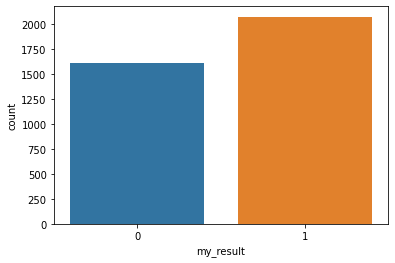

In [14]:
sns.countplot(x='my_result', data=chess_df);

Как мы видим, выигрываю я почаще

In [15]:
classes = chess_df.my_result.value_counts()
percent_of_wins = round(classes[1] / classes.sum(), 3)
print('Процент побед (класс 1) = ', percent_of_wins)

Процент побед (класс 1) =  0.562


Доля процента класса 1 равна 0.562. Т.е. если бы наша модель всегда предсказывала победу в любом случае, её accuracy score был бы равен 0.562. Желательно достичь показателя accuracy больше этого :)

<AxesSubplot:xlabel='percent_of_wins', ylabel='my_color'>

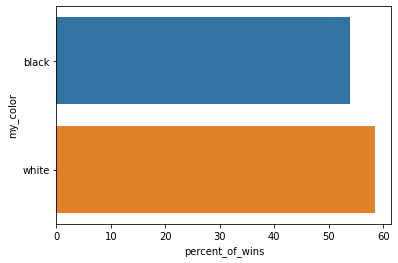

In [16]:
a = chess_df.groupby('my_color').agg({'my_result': 'mean'}).reset_index()
a = a.replace({0: 'black', 1: 'white'})
a.my_result = a.my_result * 100
a = a.rename(columns={'my_result': 'percent_of_wins'})
sns.barplot(x=a.percent_of_wins, y=a.my_color, orient='h')

Также статистика говорит, что белым цветом я выигрываю почаще (58.5% партий), чем черными (53.8%)

#### Далее проанализируем и преобразуем колонку Events

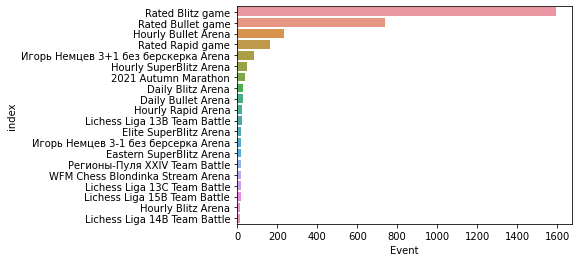

In [17]:
events = raw_data.Event.value_counts().to_frame().reset_index().head(20)
sns.barplot(data=events, x='Event', y='index');

Наиболее часто встречаемые события - не турнирные игры (Rated Blitz game, Rated Bullet game). Остальное - это игры, сыгранные в различных турнирах. На основании этого предлагаю сделать категориальную переменную Event, где 0 - это не турнирные игры, 1 - турнирные (все остальные). Разделять Blitz game и Bullet game не вижу смысла, так как это разделение будет в переменной, отвечающей за контроль времени.

In [18]:
chess_df['event'] = raw_data.Event.replace(['Rated Blitz game', 'Rated Bullet game', 'Casual Blitz game',\
                                            'Rated Rapid game'], 0)
chess_df.loc[chess_df.event != 0, 'event'] = 1
chess_df['event'] = chess_df['event'].astype('uint8')

In [19]:
chess_df['event'].value_counts() #   0 - не турнир,   1 - турнир

0    2493
1    1197
Name: event, dtype: int64

In [20]:
print('Размерность основного датафрейма:', chess_df.shape)
chess_df.head()

Размерность основного датафрейма: (3690, 5)


,Date_Time,date_,my_result,my_color,event
0,2021-12-15 08:15:19,2021-12-15,0,0,0
1,2021-12-15 08:12:19,2021-12-15,1,1,0
2,2021-12-15 08:00:26,2021-12-15,0,0,0
3,2021-12-14 18:47:54,2021-12-14,0,1,0
4,2021-12-13 17:38:15,2021-12-13,0,0,0


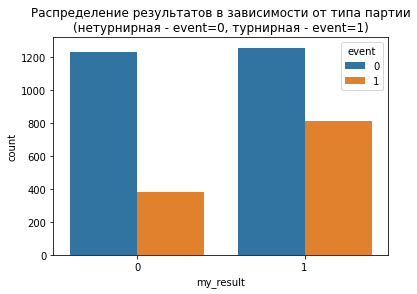

In [21]:
sns.countplot(x='my_result', hue='event', data=chess_df)
plt.title('Распределение результатов в зависимости от типа партии\n(нетурнирная - event=0, турнирная - event=1)');

По данной диаграмме можно сказать, что в нетурнирных партиях (синие столбики) количество побед и поражений почти одинаковое, а вот в турнирах (оранжевые столбики) доля побед значительно возрастает

#### Добавляю переменные my_rating (мой текущий рейтинг), rating_diff (разница между моим рейтингом и рейтингом соперника), opp_rating (рейтинг соперника)

In [22]:
chess_df['my_rating'] = raw_data['WhiteElo'].where(raw_data['White'] == 'shahmatpatblog', raw_data['BlackElo']).astype('uint16')

In [23]:
chess_df['rating_diff'] = raw_data['WhiteElo'].astype('int16') - raw_data['BlackElo'].astype('int16')
chess_df['rating_diff'] = chess_df['rating_diff'].where(chess_df['my_color'] == 1, -chess_df['rating_diff'])

Если rating_diff > 0, значит мой рейтинг больше рейтинга оппонента, если < 0 - значит меньше

In [24]:
chess_df['opp_rating'] = (chess_df['my_rating'] - chess_df['rating_diff']).astype('uint16')

In [25]:
print('Размерность основного датафрейма:', chess_df.shape)
chess_df.head()

Размерность основного датафрейма: (3690, 8)


,Date_Time,date_,my_result,my_color,event,my_rating,rating_diff,opp_rating
0,2021-12-15 08:15:19,2021-12-15,0,0,0,2298,17,2281
1,2021-12-15 08:12:19,2021-12-15,1,1,0,2291,-56,2347
2,2021-12-15 08:00:26,2021-12-15,0,0,0,2290,-55,2345
3,2021-12-14 18:47:54,2021-12-14,0,1,0,2296,6,2290
4,2021-12-13 17:38:15,2021-12-13,0,0,0,2302,52,2250


Значения рейтингов и разность моего рейтинга с соперником - весьма сильные признаки. Давайте взглянем на их скэттер плот в зависимости от результата партии 

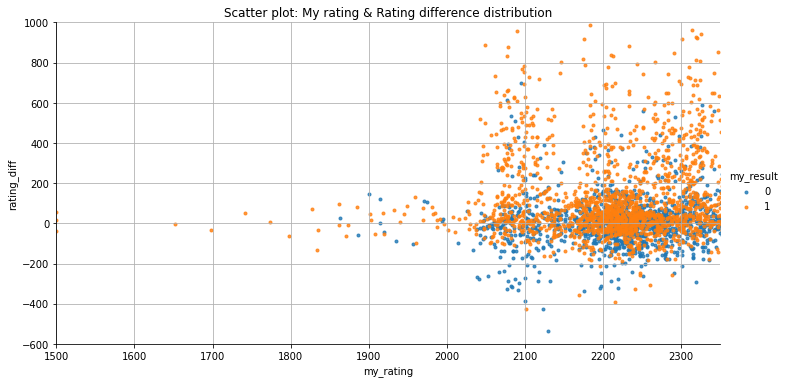

In [26]:
ax = sns.lmplot(x='my_rating', y='rating_diff', data=chess_df, hue='my_result', fit_reg=False, markers='.', aspect=2)
plt.title('Scatter plot: My rating & Rating difference distribution')
plt.grid()
plt.xlim([1500, 2350])
plt.ylim([-600, 1000]);

Как мы видим, чем больше мой рейтинг над рейтингом соперника (rating_diff > 0), тем чаще я побеждаю, и наоборот. Что, собственно говоря, предельно логично

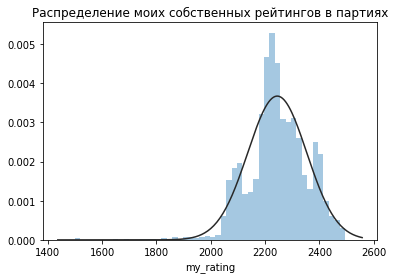

In [27]:
sns.distplot(chess_df['my_rating'], kde=False, fit=norm)
plt.title('Распределение моих собственных рейтингов в партиях');

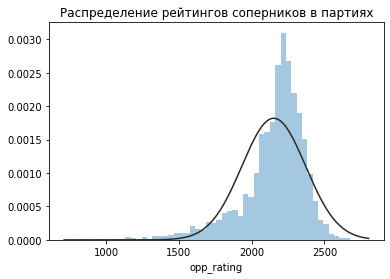

In [28]:
sns.distplot(chess_df['opp_rating'], kde=False, fit=norm)
plt.title('Распределение рейтингов соперников в партиях');

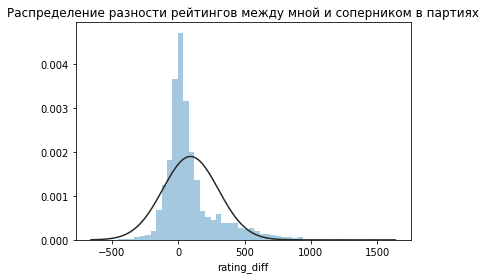

In [29]:
sns.distplot(chess_df['rating_diff'], kde=False, fit=norm)
plt.title('Распределение разности рейтингов между мной и соперником в партиях');

#### На основе анализа колонки TimeControl создаю категориальную переменную time_control, указывающую тип контроля времени

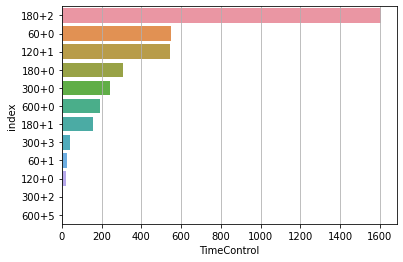

In [30]:
sns.barplot(data=raw_data.TimeControl.value_counts().to_frame().reset_index(), x='TimeControl', y='index')
plt.grid(axis='x')

Давайте разбираться в контролях времени. Почти половину партий от общего числа я сыграл с контролем 180+2 (3 минуты с добавлением 2 с на ход). Немало партий в пулю - 120+1 (т.н "ленивая пуля") и 60+0 ("обычная пуля"). Также есть довольно "медленные" контроли времени - 600+0 (рапид) и 300+3. Предлагаю создать две переменные. Первая - обычное дамми-кодирование этой переменной. Вторая - близкие по таймингу типы контроля времени объединить в две основные группы - быстрая пуля 60+0, 60+1 (0), медленная пуля 120+0, 120+1, 180+0 (1), блиц 180+1, 180+2, 300+0 (2), рапид 300+2, 300+3, 600+0, 600+5 (3).

In [31]:
chess_df['t_ctrl'] = raw_data.TimeControl

In [32]:
chess_df = pd.get_dummies(chess_df)

In [33]:
chess_df['time_control'] = raw_data.TimeControl \
                            .replace(['60+0', '60+1'], 0) \
                            .replace(['120+0', '120+1', '180+0'], 1) \
                            .replace(['180+1', '180+2', '300+0'], 2) \
                            .replace(['300+2', '300+3', '600+0', '600+5'], 3)
chess_df['time_control'] = chess_df['time_control'].astype('uint8')

In [34]:
print('Размерность основного датафрейма:', chess_df.shape)
chess_df.head()

Размерность основного датафрейма: (3690, 21)


,Date_Time,date_,my_result,my_color,event,my_rating,...,t_ctrl_300+3,t_ctrl_60+0,t_ctrl_60+1,t_ctrl_600+0,t_ctrl_600+5,time_control
0,2021-12-15 08:15:19,2021-12-15,0,0,0,2298,...,0,0,0,0,0,2
1,2021-12-15 08:12:19,2021-12-15,1,1,0,2291,...,0,0,0,0,0,2
2,2021-12-15 08:00:26,2021-12-15,0,0,0,2290,...,0,0,0,0,0,2
3,2021-12-14 18:47:54,2021-12-14,0,1,0,2296,...,0,0,0,0,0,2
4,2021-12-13 17:38:15,2021-12-13,0,0,0,2302,...,0,0,0,0,0,2


In [35]:
chess_df['time_control'].value_counts()

2    2001
1     874
0     577
3     238
Name: time_control, dtype: int64

Глянем, как я играю в зависимости от контроля времени

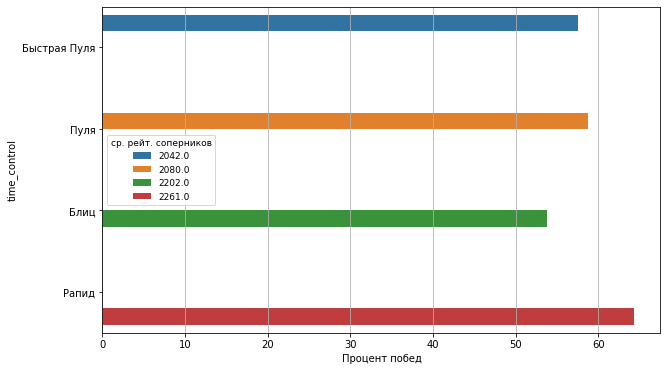

In [36]:
b = chess_df.groupby('time_control').agg({'my_result': 'mean', 'opp_rating': 'mean'}).reset_index()
b = b.replace({0: 'Быстрая Пуля', 1: 'Пуля', 2: 'Блиц', 3: 'Рапид'})
b.my_result = b.my_result * 100
b.opp_rating = b.opp_rating.round(0)
b = b.rename(columns={'my_result': 'Процент побед', 'opp_rating': 'Средний рейтинг соперников'})
plt.figure(figsize=(10, 6))
sns.barplot(x=b['Процент побед'], y=b.time_control, hue=b['Средний рейтинг соперников'], orient='h')
plt.grid(axis='x')
plt.legend(loc='center left', title='ср. рейт. соперников', fontsize=9, title_fontsize=9);

С разными контролями времени я играю с разным успехом. Наиболее часто я выигрываю с контролем времени "рапид"

#### Добавляю переменные - день недели и час суток игры (вдруг есть зависимость с моими результатами, например, в рабочие дни играю хуже, чем в выходные, вечером лучше, чем утром)

Создаю: day_of_week - категориальная переменная, от 1 до 7, обозначающая день недели игры (1 - Monday, ..., 7 - Sunday)

hour_of_game - час суток (время UTF, т.е. для получения моего времени надо прибавить +4 часа)

In [37]:
chess_df[['day_of_week']] = chess_df[['Date_Time']].applymap(lambda x: x.isoweekday()).astype('uint16')
chess_df[['hour_of_game']] = chess_df[['Date_Time']].applymap(lambda z: z.time().hour + 4).astype('uint16')

In [38]:
chess_df[['hour_of_game']] = chess_df[['hour_of_game']].replace({24: 0, 25:1, 26:2, 27:3}).astype('uint16')
chess_df['hour_of_game'].value_counts()

22    513
21    413
17    326
23    318
16    248
20    239
12    238
18    217
13    185
19    158
11    145
15    143
14    127
0     125
9      95
10     93
8      49
1      29
2      11
7       8
6       8
3       2
Name: hour_of_game, dtype: int64

In [39]:
print('Размерность основного датафрейма:', chess_df.shape)
chess_df.head()

Размерность основного датафрейма: (3690, 23)


,Date_Time,date_,my_result,my_color,event,my_rating,...,t_ctrl_60+1,t_ctrl_600+0,t_ctrl_600+5,time_control,day_of_week,hour_of_game
0,2021-12-15 08:15:19,2021-12-15,0,0,0,2298,...,0,0,0,2,3,12
1,2021-12-15 08:12:19,2021-12-15,1,1,0,2291,...,0,0,0,2,3,12
2,2021-12-15 08:00:26,2021-12-15,0,0,0,2290,...,0,0,0,2,3,12
3,2021-12-14 18:47:54,2021-12-14,0,1,0,2296,...,0,0,0,2,2,22
4,2021-12-13 17:38:15,2021-12-13,0,0,0,2302,...,0,0,0,2,1,21


Гистограмма распределения результатов по дням недели выгляди так:

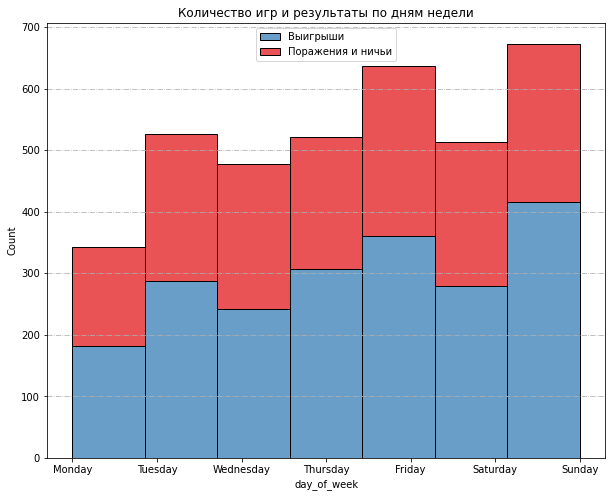

In [40]:
plt.figure(figsize=(10, 8))
sns.histplot(data=chess_df, x=chess_df.day_of_week, hue='my_result', bins=7, multiple='stack', palette='Set1')
plt.xticks(ticks=range(1, 8), labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.legend(('Выигрыши', 'Поражения и ничьи'), loc='upper center')
plt.grid(axis='y', linestyle='-.')
plt.title('Количество игр и результаты по дням недели')
plt.plot();

К выходным количество игр возрастает, и наибольшая доля побед именно в выходные. Логично, ведь я свеж и не отвлекаюсь на работу :)

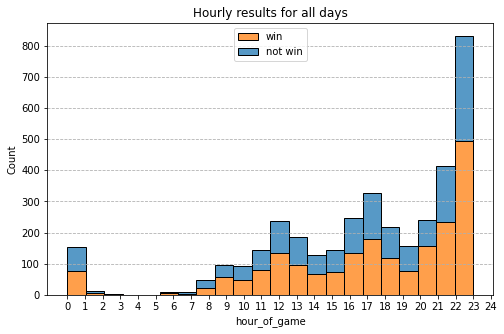

In [41]:
plt.figure(figsize=(8, 5))
sns.histplot(data=chess_df, x=chess_df.hour_of_game, hue='my_result', bins=22, multiple='stack')
plt.xticks(ticks=range(25))
plt.legend(('win', 'not win'), loc='upper center')
plt.grid(axis='y', linestyle='--')
plt.title('Hourly results for all days')
plt.plot();

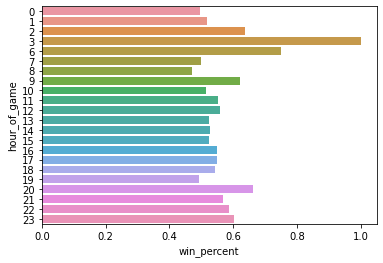

In [42]:
hours_stat = chess_df.groupby('hour_of_game').agg({'my_result': 'mean', 'my_color': 'count', 'opp_rating': 'mean'}).reset_index()
hours_stat = hours_stat.rename(columns={'my_result': 'win_percent', 'my_color': 'games_played'})
hours_stat['opp_rating'] = hours_stat['opp_rating'].astype('uint16')
sns.barplot(x='win_percent', y='hour_of_game', data=hours_stat, orient='h');

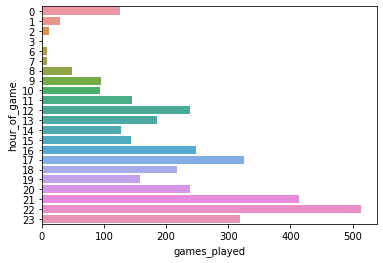

In [43]:
sns.barplot(x='games_played', y='hour_of_game', data=hours_stat, orient='h');

Из почасового распределения результатов можно сделать несколько интересных замечаний. Во-первых, есть несколько пиков - отрезков времени, когда я чаще всего играю. Это 12 часов (обеденный перерыв), 17 часов (окончание работы, еду домой), 21-23 (вечернее время дома). Во-вторых, есть "плохие" часы, когда результаты не очень (в начале дня, поздно вечером), и "хорошие часы", когда я чаще бываю в ударе. В-третьих, интересно посмотреть на это распределение только для рабочих дней и только для выходных.

In [44]:
weekend = chess_df[chess_df.day_of_week >= 6]
# plt.figure(figsize=(10, 6))
# sns.histplot(data=weekend, x=weekend.hour_of_game, hue='my_result', bins=21, multiple='stack')
# plt.xticks(ticks=range(25))
# plt.legend(('win', 'not win'), loc='upper left')
# plt.grid(axis='y', linestyle='--')
# plt.title('Hourly results for weekends')
# plt.plot();

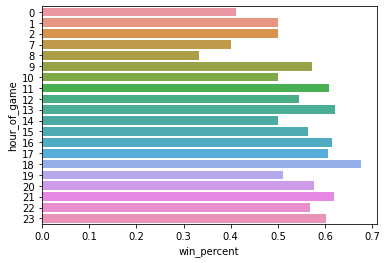

In [45]:
w_hours_stat = weekend.groupby('hour_of_game').agg({'my_result': 'mean', 'my_color': 'count', 'opp_rating': 'mean'}).reset_index()
w_hours_stat = w_hours_stat.rename(columns={'my_result': 'win_percent', 'my_color': 'games_played'})
w_hours_stat['opp_rating'] = w_hours_stat['opp_rating'].astype('uint16')
sns.barplot(x='win_percent', y='hour_of_game', data=w_hours_stat, orient='h');

Выше показано распределение результатов на выходных (праздничные дни я не считал). Распределение доли побед отличается от общей картины (по всем дням)

In [46]:
workdays = chess_df[chess_df.day_of_week < 6]
# plt.figure(figsize=(10, 6))
# sns.histplot(data=workdays, x=workdays.hour_of_game, hue='my_result', bins=19, multiple='stack')
# plt.xticks(ticks=range(25))
# plt.legend(('win', 'not win'), loc='upper left')
# plt.grid(axis='y', linestyle='--')
# plt.title('Hourly results for workdays')
# plt.plot();

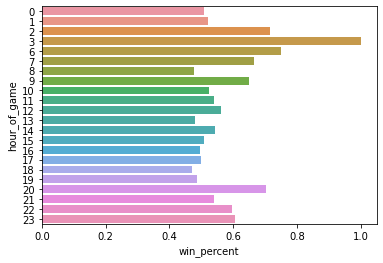

In [47]:
wo_hours_stat = workdays.groupby('hour_of_game').agg({'my_result': 'mean', 'my_color': 'count', 'opp_rating': 'mean'}).reset_index()
wo_hours_stat = wo_hours_stat.rename(columns={'my_result': 'win_percent', 'my_color': 'games_played'})
wo_hours_stat['opp_rating'] = wo_hours_stat['opp_rating'].astype('uint16')
sns.barplot(x='win_percent', y='hour_of_game', data=wo_hours_stat, orient='h');

Очевидно, что почасовая статистика по будням и по выходным разнится, поэтому нужно выделить отдельную переменную, указывающую, игралась ли партия в выходной или нет

#### its_weekend - партия сыграна в выходной (1) или нет (0)

In [48]:
chess_df['its_weekend'] = chess_df.day_of_week.replace([1, 2, 3, 4, 5], 0).replace([6, 7], 1).astype('uint8')

In [49]:
print('Размерность основного датафрейма:', chess_df.shape)
chess_df.head()

Размерность основного датафрейма: (3690, 24)


,Date_Time,date_,my_result,my_color,event,my_rating,...,t_ctrl_600+0,t_ctrl_600+5,time_control,day_of_week,hour_of_game,its_weekend
0,2021-12-15 08:15:19,2021-12-15,0,0,0,2298,...,0,0,2,3,12,0
1,2021-12-15 08:12:19,2021-12-15,1,1,0,2291,...,0,0,2,3,12,0
2,2021-12-15 08:00:26,2021-12-15,0,0,0,2290,...,0,0,2,3,12,0
3,2021-12-14 18:47:54,2021-12-14,0,1,0,2296,...,0,0,2,2,22,0
4,2021-12-13 17:38:15,2021-12-13,0,0,0,2302,...,0,0,2,1,21,0


#### Создаю признак part_of_day - время дня, когда игралась партия и посмотрим, как я играю в разное время дня.

In [50]:
chess_df['part_of_day'] = chess_df.hour_of_game.replace([4, 5, 6, 7, 8, 9, 10, 11], 'morning') \
                                    .replace([12, 13, 14, 15, 16, 17, 18], 'afternoon') \
                                    .replace([19, 20, 21, 22, 23, 0, 1, 2, 3], 'evening')

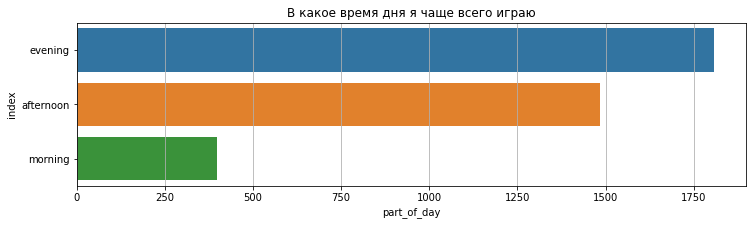

In [51]:
plt.figure(figsize=(12, 3))
sns.barplot(data=chess_df.part_of_day.value_counts().to_frame().reset_index(), x='part_of_day', y='index')
plt.title('В какое время дня я чаще всего играю')
plt.grid(axis='x');

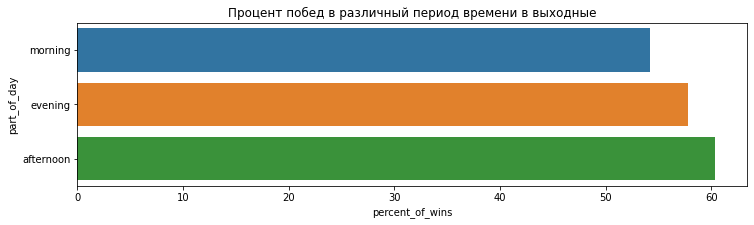

In [52]:
c = chess_df[chess_df.its_weekend == 1].groupby('part_of_day').agg({'my_result': 'mean'}).reset_index().sort_values(by='my_result')
c.my_result = c.my_result * 100
c = c.rename(columns={'my_result': 'percent_of_wins'})
plt.figure(figsize=(12, 3))
plt.title('Процент побед в различный период времени в выходные')
sns.barplot(x=c.percent_of_wins, y=c.part_of_day, orient='h');

В выходные наиболее успешное время для меня - вечер

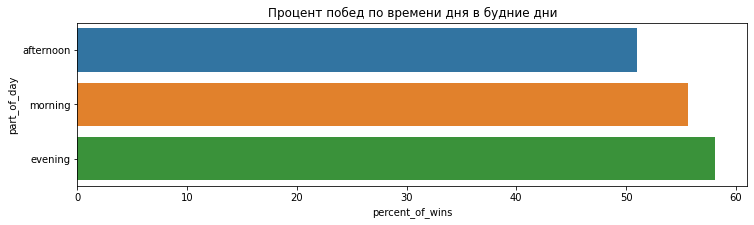

In [53]:
d = chess_df[chess_df.its_weekend == 0].groupby('part_of_day').agg({'my_result': 'mean'}).reset_index().sort_values(by='my_result')
d.my_result = d.my_result * 100
d = d.rename(columns={'my_result': 'percent_of_wins'})
plt.figure(figsize=(12, 3))
plt.title('Процент побед по времени дня в будние дни')
sns.barplot(x=d.percent_of_wins, y=d.part_of_day, orient='h');

В рабочие дни ситуация немного другая. Вечер также саое успешное время дня. А вот после обеда статистика хуже, чем утром. В целом, разбиение на утро, день и вечер выглядит обоснованным, создаю переменную для дамми-кодирования

#### Проанализировав полученные данные, я решил оставить данные part_of_day, только обработаю эту переменную dummy-кодированием, чтобы получить 3 категориальные переменные, в какое время я играл.

In [54]:
chess_df = pd.get_dummies(data=chess_df)

In [55]:
print('Размерность основного датафрейма:', chess_df.shape)
chess_df.head()

Размерность основного датафрейма: (3690, 27)


,Date_Time,date_,my_result,my_color,event,my_rating,...,day_of_week,hour_of_game,its_weekend,part_of_day_afternoon,part_of_day_evening,part_of_day_morning
0,2021-12-15 08:15:19,2021-12-15,0,0,0,2298,...,3,12,0,1,0,0
1,2021-12-15 08:12:19,2021-12-15,1,1,0,2291,...,3,12,0,1,0,0
2,2021-12-15 08:00:26,2021-12-15,0,0,0,2290,...,3,12,0,1,0,0
3,2021-12-14 18:47:54,2021-12-14,0,1,0,2296,...,2,22,0,0,1,0
4,2021-12-13 17:38:15,2021-12-13,0,0,0,2302,...,1,21,0,0,1,0


In [56]:
# chess_df.drop(columns=['hour_of_game', 'day_of_week'], inplace=True)

#### Создаю переменные, которые содержат информацию: сколько партий я сыграл за последние 7 дней (last_7days_games) и какой процент побед в этих партиях (last_7days_win_rate)

In [57]:
dated_X = chess_df.sort_values(by='Date_Time').set_index('date_') #создаю датафрейм с DateTime индексом
#создаю датафрейм, где каждому дню соответствует, сколько партий я сыграл за последние 7 дней
last_7d_stats = dated_X[['my_result']].resample('d').count().rolling(8, min_periods=1).sum() - dated_X[['my_result']].resample('d').count()
my_wins = dated_X[['my_result']].loc[ dated_X['my_result'] == 1] #для подсчете моих побед
#создаю датафрейм, где каждому дню соответствует, сколько партий я выиграл за последние 7 дней
last_7d_wins = my_wins.resample('d').count().rolling(8, min_periods=1).sum() - my_wins.resample('d').count()
#объединяю два датафрейма в один
last_7d_stats = last_7d_stats.merge(last_7d_wins, left_index=True, right_index=True, how='inner')
last_7d_stats = last_7d_stats.reset_index().rename(columns={'my_result_x': 'last_7days_games',
                                                                 'my_result_y': 'last_7days_wins'})
#далее подсчитываю процент выигранных партий за последние 7 дней - отношение кол-ва побед к кол-ву игр
#для этого есть вспомогательная функция в библиотеке chess_lib - count_rate

In [58]:
last_7d_stats['last_7days_win_rate'] = count_rate(last_7d_stats.last_7days_wins, last_7d_stats.last_7days_games).astype('float32')
last_7d_stats[['last_7days_games', 'last_7days_wins']] = last_7d_stats[['last_7days_games', 'last_7days_wins']].astype('uint16')
print('Размерность датафрейма статистики за 7 последних дней:', last_7d_stats.shape)
last_7d_stats.head()

Размерность датафрейма статистики за 7 последних дней: (569, 4)


,date_,last_7days_games,last_7days_wins,last_7days_win_rate
0,2020-05-26,0,0,0.000
1,2020-05-27,10,8,0.800
2,2020-05-28,15,10,0.667
3,2020-05-29,18,13,0.722
4,2020-05-30,31,20,0.645


Данные статистики за последние 7 дней для каждой игры получены. Соединяем эти данные с основной таблицей

In [59]:
chess_df = pd.merge(left=chess_df, right=last_7d_stats, on='date_', how='inner')

In [60]:
print('Размерность основного датафрейма:', chess_df.shape)
chess_df.head()

Размерность основного датафрейма: (3690, 30)


,Date_Time,date_,my_result,my_color,event,my_rating,...,part_of_day_afternoon,part_of_day_evening,part_of_day_morning,last_7days_games,last_7days_wins,last_7days_win_rate
0,2021-12-15 08:15:19,2021-12-15,0,0,0,2298,...,1,0,0,13,9,0.692
1,2021-12-15 08:12:19,2021-12-15,1,1,0,2291,...,1,0,0,13,9,0.692
2,2021-12-15 08:00:26,2021-12-15,0,0,0,2290,...,1,0,0,13,9,0.692
3,2021-12-14 18:47:54,2021-12-14,0,1,0,2296,...,0,1,0,18,10,0.556
4,2021-12-13 17:38:15,2021-12-13,0,0,0,2302,...,0,1,0,21,11,0.524


#### Создаю переменные, содержащие информацию о моей статистике за предыдущие партии, которые я сыграл в текущий день. count_today_games - сколько партий выграл сегодня до этого, win_rate_today_games - процент побед в текущий день

In [61]:
dd = chess_df[['Date_Time', 'date_', 'my_result']] #промежуточный датафрейм
list_count_today_games, list_count_today_wins= [], []
for i, row in dd.iterrows():
    #print(row)
    subseries_games = dd[['Date_Time']].loc[(dd['Date_Time'] < row[0]) & (dd['date_'] == row[1])] #серия с играми за день
    subseries_wins = dd[['Date_Time']].loc[(dd['Date_Time'] < row[0]) & (dd['date_'] == row[1]) & dd['my_result'] == 1] #с победами
    list_count_today_games.append(subseries_games.shape[0]) #считаю количество игр за каждый день и добавляю в список
    list_count_today_wins.append(subseries_wins.shape[0]) #аналогично для побед
df_count_today = pd.DataFrame(data=np.array((list_count_today_games, list_count_today_wins)).T,
                             columns=['count_today_games', 'win_today_games']) #создаю датафрейм со статистикой

In [62]:
df_count_today['win_rate_today_games'] = count_rate(df_count_today.win_today_games, df_count_today.count_today_games).astype('float32')
df_count_today[['count_today_games', 'win_today_games']] = df_count_today[['count_today_games', 'win_today_games']].astype('uint16')
print('Размерность датафрейма статистики за текущий день:', df_count_today.shape)
df_count_today.head()

Размерность датафрейма статистики за текущий день: (3690, 3)


,count_today_games,win_today_games,win_rate_today_games
0,2,1,0.500
1,1,0,0.000
2,0,0,0.000
3,0,0,0.000
4,0,0,0.000


# Создать переменную разность между количеством побед и количеством поражений за неделю и за один день

Датафрейм со статистикой за текущий день для каждой партии создан. Объединяем его с основным датафреймом!

In [63]:
chess_df = pd.merge(left=chess_df, right=df_count_today, left_index=True, right_index=True, how='inner')

In [64]:
print('Размерность основного датафрейма:', chess_df.shape)
chess_df.head()

Размерность основного датафрейма: (3690, 33)


,Date_Time,date_,my_result,my_color,event,my_rating,...,last_7days_games,last_7days_wins,last_7days_win_rate,count_today_games,win_today_games,win_rate_today_games
0,2021-12-15 08:15:19,2021-12-15,0,0,0,2298,...,13,9,0.692,2,1,0.500
1,2021-12-15 08:12:19,2021-12-15,1,1,0,2291,...,13,9,0.692,1,0,0.000
2,2021-12-15 08:00:26,2021-12-15,0,0,0,2290,...,13,9,0.692,0,0,0.000
3,2021-12-14 18:47:54,2021-12-14,0,1,0,2296,...,18,10,0.556,0,0,0.000
4,2021-12-13 17:38:15,2021-12-13,0,0,0,2302,...,21,11,0.524,0,0,0.000


#### Удаляю из набора данных уже не нужные признаки времени Date_Time и date_

In [65]:
chess_df.drop(columns=['Date_Time', 'date_'], inplace=True)

In [66]:
print('Размерность основного датафрейма:', chess_df.shape)
chess_df.head()

Размерность основного датафрейма: (3690, 31)


,my_result,my_color,event,my_rating,rating_diff,opp_rating,...,last_7days_games,last_7days_wins,last_7days_win_rate,count_today_games,win_today_games,win_rate_today_games
0,0,0,0,2298,17,2281,...,13,9,0.692,2,1,0.500
1,1,1,0,2291,-56,2347,...,13,9,0.692,1,0,0.000
2,0,0,0,2290,-55,2345,...,13,9,0.692,0,0,0.000
3,0,1,0,2296,6,2290,...,18,10,0.556,0,0,0.000
4,0,0,0,2302,52,2250,...,21,11,0.524,0,0,0.000


#### Анализ численных переменных (numeric variables)

In [67]:
numeric = ['my_rating', 'rating_diff', 'opp_rating', 'last_7days_games', 'last_7days_wins', 'last_7days_win_rate',\
           'count_today_games', 'win_today_games', 'win_rate_today_games']
print('В датасете всего %d численных переменных' % len(numeric))

В датасете всего 9 численных переменных


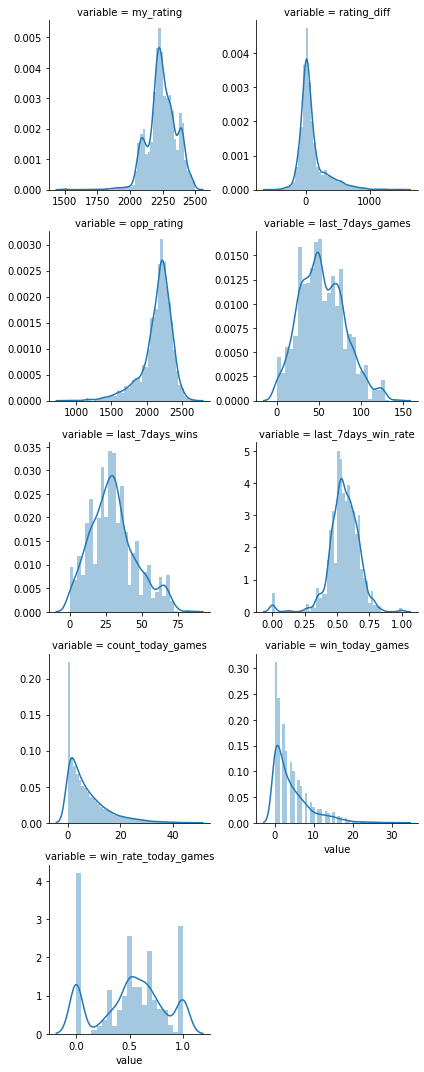

In [68]:
f = pd.melt(chess_df, value_vars=numeric)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

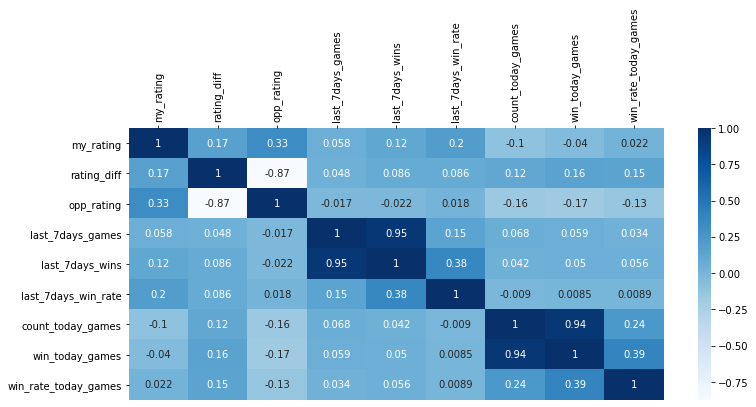

In [87]:
plt.figure(figsize=(12, 5))
g = sns.heatmap(chess_df[numeric].corr(), annot=True, cmap=plt.cm.Blues)
g.xaxis.set_ticks_position('top')
g.xaxis.set_tick_params(rotation=90);

#### Преобразования, которые я бы хотел применить к некоторым переменным:

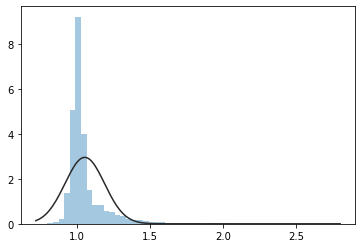

In [76]:
sns.distplot((chess_df['my_rating'] / chess_df['opp_rating']), kde=False, fit=norm);

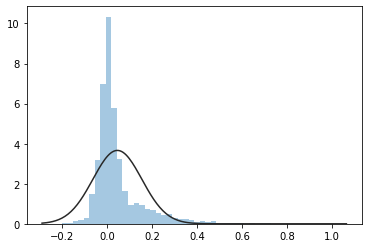

In [77]:
sns.distplot(np.log(chess_df['my_rating'] / chess_df['opp_rating']), kde=False, fit=norm);

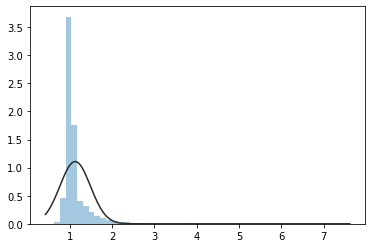

In [85]:
sns.distplot(np.power(chess_df['my_rating'] / chess_df['opp_rating'], 2), kde=False, fit=norm);

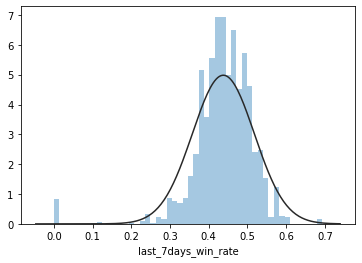

In [70]:
sns.distplot(np.log1p(chess_df['last_7days_win_rate']), kde=False, fit=norm);

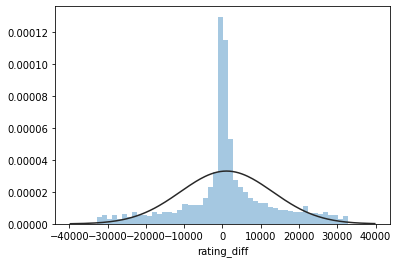

In [71]:
sns.distplot((chess_df['rating_diff'] * np.abs(chess_df['rating_diff'])), kde=False, fit=norm);

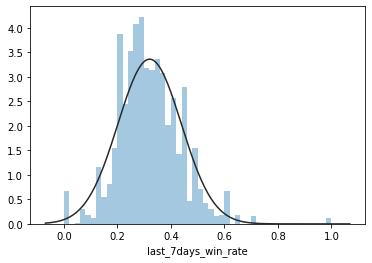

In [72]:
sns.distplot(np.power(chess_df['last_7days_win_rate'], 2), kde=False, fit=norm);

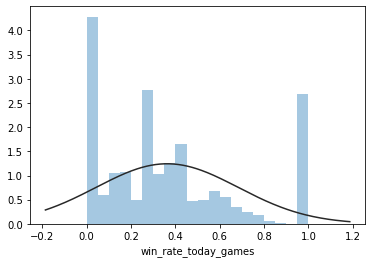

In [73]:
sns.distplot(np.power(chess_df['win_rate_today_games'], 2), kde=False, fit=norm);

#### Добавляю новые переменные в таблицу

In [88]:
chess_df['me_opp_ratio'] = chess_df['my_rating'] / chess_df['opp_rating']
chess_df['log_me_opp_ratio'] = np.log(chess_df['me_opp_ratio'])
chess_df['quad_me_opp_ratio'] = np.power(chess_df['me_opp_ratio'], 2)
chess_df['quad_rating_diff'] = chess_df['rating_diff'] * np.abs(chess_df['rating_diff'])
chess_df['quad_last_7days_win_rate'] = np.power(chess_df['last_7days_win_rate'], 2)
chess_df['quad_win_rate_today_games'] = np.power(chess_df['win_rate_today_games'], 2)

In [89]:
chess_df.describe()

,my_result,my_color,event,my_rating,rating_diff,opp_rating,...,me_opp_ratio,log_me_opp_ratio,quad_me_opp_ratio,quad_rating_diff,quad_last_7days_win_rate,quad_win_rate_today_games
count,3690.000,3690.000,3690.000,3690.000,3690.000,3690.000,...,3690.000,3690.000,3690.000,3690.000,3690.000,3690.000
mean,0.562,0.497,0.324,2244.528,92.671,2151.857,...,1.055,0.047,1.131,1049.824,0.321,0.363
std,0.496,0.500,0.468,108.620,209.804,219.297,...,0.135,0.109,0.360,12069.874,0.119,0.321
min,0.000,0.000,0.000,1500.000,-536.000,839.000,...,0.799,-0.224,0.638,-32703.000,0.000,0.000
25%,0.000,0.000,0.000,2187.000,-22.000,2070.000,...,0.990,-0.010,0.981,-2304.000,0.250,0.111
50%,1.000,0.000,0.000,2241.000,34.000,2199.000,...,1.015,0.015,1.031,196.000,0.307,0.284
75%,1.000,1.000,1.000,2316.000,132.000,2287.000,...,1.063,0.061,1.130,5625.000,0.391,0.510
max,1.000,1.000,1.000,2494.000,1516.000,2676.000,...,2.721,1.001,7.404,32761.000,1.000,1.000


In [90]:
numeric.extend(['me_opp_ratio', 'log_me_opp_ratio', 'quad_me_opp_ratio', 'quad_rating_diff',\
                'quad_last_7days_win_rate', 'quad_win_rate_today_games'])

['my_rating',
 'rating_diff',
 'opp_rating',
 'last_7days_games',
 'last_7days_wins',
 'last_7days_win_rate',
 'count_today_games',
 'win_today_games',
 'win_rate_today_games',
 'me_opp_ratio',
 'log_me_opp_ratio',
 'quad_me_opp_ratio',
 'quad_rating_diff',
 'quad_last_7days_win_rate',
 'quad_win_rate_today_games']

In [95]:
chess_df[numeric].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3690 entries, 0 to 3689
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   my_rating                  3690 non-null   uint16 
 1   rating_diff                3690 non-null   int16  
 2   opp_rating                 3690 non-null   uint16 
 3   last_7days_games           3690 non-null   uint16 
 4   last_7days_wins            3690 non-null   uint16 
 5   last_7days_win_rate        3690 non-null   float32
 6   count_today_games          3690 non-null   uint16 
 7   win_today_games            3690 non-null   uint16 
 8   win_rate_today_games       3690 non-null   float32
 9   me_opp_ratio               3690 non-null   float64
 10  log_me_opp_ratio           3690 non-null   float64
 11  quad_me_opp_ratio          3690 non-null   float64
 12  quad_rating_diff           3690 non-null   int16  
 13  quad_last_7days_win_rate   3690 non-null   float

#### Смотрим корреляцию между числовыми переменными и целевой

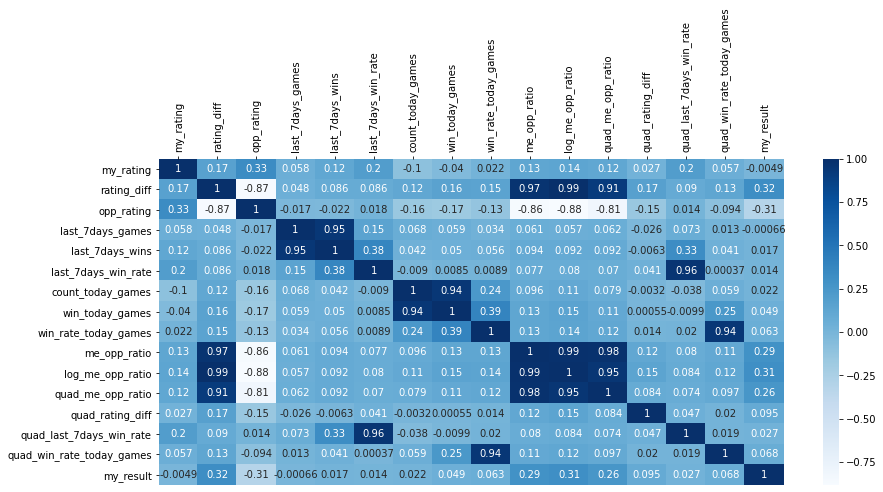

In [97]:
vv = pd.concat([chess_df[numeric], chess_df['my_result']], axis=1)
plt.figure(figsize=(14, 6))
g = sns.heatmap(vv.corr(), annot=True, cmap=plt.cm.Blues)
g.xaxis.set_ticks_position('top')
g.xaxis.set_tick_params(rotation=90);

Удаляю из таблицы следующие переменные:

my_rating, last_7days_games - из-за низкой корреляции с целовой переменной. last_7days_games также имеет сильную корреляцию с last_7days_wins

last_7days_win_rate - из-за высокой корреляции с quad_last_7days_win_rate. Переменные похожи между собой, но у первой корреляция с целевой переменной ниже, поэтому дропаем ее

count_today_games - из-за высокой корреляции с win_today_games

In [98]:
chess_df.drop(columns=['my_rating', 'last_7days_games', 'last_7days_win_rate', 'count_today_games'], inplace=True)

Проверяем полученный датафрейм на типы данных и пропуски

In [99]:
chess_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3690 entries, 0 to 3689
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   my_result                  3690 non-null   uint8  
 1   my_color                   3690 non-null   uint8  
 2   event                      3690 non-null   uint8  
 3   rating_diff                3690 non-null   int16  
 4   opp_rating                 3690 non-null   uint16 
 5   t_ctrl_120+0               3690 non-null   uint8  
 6   t_ctrl_120+1               3690 non-null   uint8  
 7   t_ctrl_180+0               3690 non-null   uint8  
 8   t_ctrl_180+1               3690 non-null   uint8  
 9   t_ctrl_180+2               3690 non-null   uint8  
 10  t_ctrl_300+0               3690 non-null   uint8  
 11  t_ctrl_300+2               3690 non-null   uint8  
 12  t_ctrl_300+3               3690 non-null   uint8  
 13  t_ctrl_60+0                3690 non-null   uint8

## 3. Создание тренировочного и тестового набора данных

#### Разделяю основной датафрейм на вектор признаков (X) и вектор целевой переменной my_result (y).

In [100]:
X = chess_df.drop(columns='my_result')
y = chess_df.my_result

In [101]:
print('Размерности X и y: ', X.shape, y.shape)

Размерности X и y:  (3690, 32) (3690,)


#### Разделяю данные на тренировочные и тестовые

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=28, shuffle=True)

In [103]:
print('Размерность обучающего набора: ', X_train.shape, y_train.shape)
print('Размерность тестового набора: ', X_test.shape, y_test.shape)

Размерность обучающего набора:  (2472, 32) (2472,)
Размерность тестового набора:  (1218, 32) (1218,)


#### Масштабирование численных переменных

Поскольку я планирую воспользоваться логистической регрессией для предсказания результатов, желательно произвести масштабирование признаков. Произведем масштабирование для всех признаков, кроме бинарных. Поскольку бинарные признаки в таблице имеют тип данных uint8, я осуществляю обучение StandardScaler() только по признакам не типа uint8, а затем их добавляю к датафрейму X вместо соответствующих исходных признаков

In [105]:
scaled = X_train.dtypes[X_train.dtypes != 'uint8'].index #признаки для масштабирования
scaled

Index(['rating_diff', 'opp_rating', 'day_of_week', 'hour_of_game',
       'last_7days_wins', 'win_today_games', 'win_rate_today_games',
       'me_opp_ratio', 'log_me_opp_ratio', 'quad_me_opp_ratio',
       'quad_rating_diff', 'quad_last_7days_win_rate',
       'quad_win_rate_today_games'],
      dtype='object')

In [109]:
scaler = StandardScaler()
X_train[scaled] = scaler.fit_transform(X_train[scaled])
X_train.head()

,rating_diff,opp_rating,day_of_week,hour_of_game,last_7days_wins,win_today_games,...,me_opp_ratio,log_me_opp_ratio,quad_me_opp_ratio,quad_rating_diff,quad_last_7days_win_rate,quad_win_rate_today_games
415,-0.045,0.790,-0.158,0.953,1.078,1.427,...,-0.138,-0.106,-0.157,0.443,0.885,0.797
2796,-0.444,-0.259,-1.175,0.953,-0.694,0.151,...,-0.406,-0.432,-0.360,-0.081,-1.115,-0.665
1029,-0.104,1.023,-1.175,0.587,1.837,-0.487,...,-0.182,-0.158,-0.191,0.296,0.917,1.987
2880,-1.217,1.177,0.860,0.222,-0.757,-0.062,...,-0.903,-1.072,-0.719,-2.281,-1.632,-0.348
3347,-0.789,0.459,1.369,-0.326,-1.770,-0.487,...,-0.643,-0.732,-0.534,-0.540,-1.747,-0.348
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3104,-0.580,0.543,-0.158,-0.691,0.065,0.576,...,-0.498,-0.548,-0.428,-0.161,0.183,-0.069
2036,-0.235,0.235,1.369,0.405,0.065,0.364,...,-0.258,-0.250,-0.249,0.054,-0.373,-0.202
1302,-0.677,0.962,1.369,0.770,0.635,1.427,...,-0.558,-0.623,-0.473,-0.298,0.586,0.347
1541,-1.237,1.512,-0.158,-0.874,2.027,-0.487,...,-0.900,-1.068,-0.717,-2.392,-0.587,-0.348


In [111]:
X_test[scaled] = scaler.transform(X_test[scaled])
X_test.head()

,my_color,event,rating_diff,opp_rating,t_ctrl_120+0,t_ctrl_120+1,...,me_opp_ratio,log_me_opp_ratio,quad_me_opp_ratio,quad_rating_diff,quad_last_7days_win_rate,quad_win_rate_today_games
2107,0,1,-0.186,0.179,0,0,...,-0.223,-0.208,-0.222,0.129,-0.276,-0.348
858,1,0,-1.037,1.242,0,0,...,-0.784,-0.915,-0.636,-1.391,-1.435,0.866
2223,1,0,-0.274,0.389,0,0,...,-0.287,-0.286,-0.271,0.006,0.411,-0.872
596,0,0,-0.391,0.850,0,0,...,-0.369,-0.387,-0.333,-0.075,0.798,1.987
2848,0,0,-0.736,0.160,0,1,...,-0.612,-0.692,-0.512,-0.413,-0.998,-1.003


Данные готовы! Давайте обучим логистическую регрессию и попробуем найти наилучший классификатор

In [112]:
print('Размерность обучающего набора: ', X_train.shape, y_train.shape)
print('Размерность тестового набора: ', X_test.shape, y_test.shape)

Размерность обучающего набора:  (2472, 32) (2472,)
Размерность тестового набора:  (1218, 32) (1218,)


## 4.Обучение моделей

#### Логистическая регрессия с L2-регуляризацией

In [157]:
clf_l2 = LogisticRegressionCV(Cs=9, cv=5, random_state=28, penalty='l2', solver='lbfgs').fit(X_train, y_train)
print('Наилучший параметр С = %f.\nЗначения accuracy для X_train:' % clf_l2.C_)
print(accuracy_score(y_train, clf_l2.predict(X_train)), '\n')
print('Значения accuracy для X_test:')
print(accuracy_score(y_test, clf_l2.predict(X_test)), '\n')

Наилучший параметр С = 0.100000.
Значения accuracy для X_train:
0.654126213592233 

Значения accuracy для X_test:
0.6543513957307061 



Значения весов переменных при обучении:

In [194]:
weights = pd.DataFrame(data=np.array([list(X_train.columns), clf_l2.coef_.flatten()]).T, columns=['Variable', 'Weight'])
weights['Weight'] = weights['Weight'].astype('float32').round(3).abs()
weights.sort_values(by='Weight', ascending=False)

,Variable,Weight
3,opp_rating,0.434
2,rating_diff,0.257
1,event,0.202
27,log_me_opp_ratio,0.198
31,quad_win_rate_today_games,0.189
19,its_weekend,0.184
14,t_ctrl_600+0,0.153
16,time_control,0.145
0,my_color,0.131
26,me_opp_ratio,0.122


#### Логистическая регрессия с L1-регуляризацией

In [158]:
clf_l1 = LogisticRegressionCV(Cs=9, cv=5, random_state=28, penalty='l1', solver='liblinear').fit(X_train, y_train)
print('Наилучший параметр С = %f.\nЗначения accuracy для X_train:' % clf_l1.C_)
print(accuracy_score(y_train, clf_l1.predict(X_train)), '\n')
print('Значения accuracy для X_test:')
print(accuracy_score(y_test, clf_l1.predict(X_test)), '\n')

Наилучший параметр С = 10.000000.
Значения accuracy для X_train:
0.6557443365695793 

Значения accuracy для X_test:
0.6444991789819376 



Значения весов переменных при обучении:

In [195]:
weights = pd.DataFrame(data=np.array([list(X_train.columns), clf_l1.coef_.flatten()]).T, columns=['Variable', 'Weight'])
weights['Weight'] = weights['Weight'].astype('float32').round(3).abs()
weights.sort_values(by='Weight', ascending=False)

,Variable,Weight
10,t_ctrl_300+2,3.413
15,t_ctrl_600+5,2.352
3,opp_rating,0.479
27,log_me_opp_ratio,0.380
2,rating_diff,0.321
1,event,0.266
31,quad_win_rate_today_games,0.246
19,its_weekend,0.227
14,t_ctrl_600+0,0.224
12,t_ctrl_60+0,0.204


#### Наилучшая точность на тестовых данных у логистической регрессии с параметрами: L2-регуляризация, C=0.1.

#### accuracy score (для X_test)= 0.654 

## Заключение

Данный проект был направлен на решение вопроса - возможно ли предсказать результат моей партии на сайте lichess.org, имея базу данных моих предыдущих партий на этом сайте? Ответ - можно, и доля правильно предсказанных ответов 65 %. Для предсказания вероятности результата использовалась логистическая регрессия, т.к. она идеально подходит для вычисления вероятностей класса. Учитывая непредсказуемость блиц-партий онлайн, 65% правильных предугадываний, считаю, довольно неплохой результат. Для достижения такого показателя, была проделана следующая работа:

- Выгружена база партий, из которой был создан первичный набор данных

- Проведен анализ данных (EDA) для формирования информативных признаков (фичей) для построения тренировочного набора данных

- На основе анализа были построены обучающий и тестовый набор данных

- Проведено обучение логистической регрессии с поиском наилучшего классификатора по параметру accuracy score на кросс-валидации.

#### Спасибо, что дочитали до конца!

### Данные, полученные в результате этого анализа, легли в основу программы "Шахматный Нострадамус". Открывай его скорей, и ты, возможно, узнаешь вероятность своей победы в шахматной партии...